In [1]:
using StatsBase, Random
using BioSequences, BioTools, MyBioTools.FluTools, TreeTools, EarthMoversDistance
using Plots
using Dates
using FastaIO
include("functions/Predictions.jl")

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/BioTools.ji for BioTools [top-level]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/MyBioTools.ji for MyBioTools [top-level]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/EarthMoversDistance.ji for EarthMoversDistance [top-level]
└ @ Base loading.jl:1184


cluster_lbi_maxima! (generic function with 1 method)

In [2]:
pyplot()
plot(rand(10),size=(1,1))

In [3]:
sp = FluTools.StrainPop("../data/newtrees/100_per_4month/aligned_ha_aa.fasta");

In [4]:
FluTools.bin_by_date!(sp, start = Date(2002,12,1), binwidth=Day(61), binspacing = Day(122));
datebins = sort(collect(keys(sp.datebin)));

In [5]:
t = read_tree("../data/newtrees/100_per_4month/results/tree_raw.nwk", NodeDataType=LBIData);
FluTools.get_lbi!(sp, t);
for (d,v) in sp.lbi_datebin
    for s in values(sp.datebin[d])
        sp.straindict[s.strain].fitness = v[s.strain]
    end
end

  0.824342 seconds (1.88 M allocations: 169.039 MiB, 31.28% gc time)


In [6]:
llm_original = FluTools.local_lbi_maximas!(t, sp, FluTools.get_tau("h3n2","ha"));

- For each local maximum, find the closest existing strain in tree distance. This will be the predictor. 
- For each local maximum, distance to consensus? A histogram of this? 
- EMD between the `i` first local maxima and the future population. Does this go through a minimum? 

In [300]:
# Replacing the internal node by the name of the closest leaf in `llm`
llm = Dict()
for db in datebins
    popnames = [x.strain for x in sp.datebin[db]]
    new = []
    for (n,lbi) in llm_original[db]
        l = closest_tree_leaf(n, t, popnames)[1]
        push!(new, (label=l, lbi=lbi))
    end
    llm[db] = new
end

In [302]:
# Let's look at the distance to consensus for a specific date bin
# The datebin `end-8` has a very split population, with four clearly distinct clades in the tree
db = datebins[end-8]
pop = sp.datebin[db]
cons = FluTools.consensus(pop)
dat = []
println(db)
for (name, lbi) in sort(llm[db], by = x->x.lbi, rev=true)
    hd = FluTools.hamming(cons.aa_seq, sp.straindict[name].aa_seq)
    println("$name - $lbi - $hd")
end
hd = FluTools.popdistance(pop, pop, disttype=:hamming_consensus)*566
println("Average distance of the pop to its consensus: $hd")

(2015-08-11, 2015-12-11)
A/Niger/3107/2015 - 1.0 - 1.0
A/Alaska/194/2015 - 0.5981640770446404 - 1.0
A/Lao/I943/2015 - 0.5896447383303429 - 0.0
A/Hunan-Yueyanglou/1756/2015 - 0.5534829397347635 - 0.0
A/Niger/3107/2015 - 0.5110306712077205 - 1.0
A/Norway/2691/2015 - 0.39275618614163665 - 2.0
A/Washington/60/2015 - 0.33101580070581077 - 3.0
A/Alabama/11/2015 - 0.2819982701676834 - 0.0
A/Alaska/194/2015 - 0.27848535920532613 - 1.0
A/Colombia/6438/2015 - 0.2727607000242475 - 10.0
A/SouthAustralia/133/2015 - 0.26731515132840006 - 2.0
A/Jiangsu-Gusu/11664/2015 - 0.23518966689466597 - 11.0
A/Jiangsu-Gusu/11664/2015 - 0.23282568545840543 - 11.0
A/Iowa/54/2015 - 0.23198490502725647 - 1.0
A/Jiangsu-Gusu/11664/2015 - 0.21017418711014654 - 11.0
A/Jiangsu-Gusu/11664/2015 - 0.20993191648375048 - 11.0
A/Brazil/636/2015 - 0.20962541499261297 - 12.0
A/Victoria/662/2015 - 0.207274779453233 - 16.0
A/Jiangsu-Chongchuan/12714/2015-egg - 0.20721310702748982 - 22.0
A/Mali/109CS/2015 - 0.20095389761588317 - 1.

In [303]:
# What's the EMD from `pop` to the future populations? 
emd_to_future = []
for db2 in datebins[end-8:end]
    emd = EarthMoversDistance.EMD([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db2]], [LongAminoAcidSeq(x.aa_seq) for x in pop])
    println("$db2 - $(emd[1].emd)")
    push!(emd_to_future, (db2[1]-db[1] ,emd[1].emd))
end

(2015-08-11, 2015-12-11) - -0.20986940081362707
(2015-12-11, 2016-04-11) - 4.2225101208330535
(2016-04-11, 2016-08-11) - 5.235828992017648
(2016-08-11, 2016-12-11) - 5.549751120830341
(2016-12-11, 2017-04-12) - 6.809640553908932
(2017-04-12, 2017-08-12) - 7.2204937756865135
(2017-08-12, 2017-12-12) - 6.878434017951235
(2017-12-12, 2018-04-13) - 6.07879151551341
(2018-04-13, 2018-08-13) - 7.243804243154367


In [258]:
# Predictor from an array of tuples (name, score)
function get_predictor(strains, sp, npred=length(strains))
    tmp = sort(strains, by = x->x.lbi, rev=true)[1:npred]
    predseqs = [LongAminoAcidSeq(sp.straindict[x.label].aa_seq) for x in tmp]
    predweight = [x.lbi for x in tmp] / sum(x.lbi for x in tmp)
    #
    predictor = Dict(k=>0. for k in predseqs)
    predinfo = Dict(n.label=>0. for n in tmp)
    for (i,s) in enumerate(predseqs)
        predictor[s] += predweight[i]
        predinfo[tmp[i].label] += predweight[i]
    end
    return predictor, predinfo
end

get_predictor (generic function with 2 methods)

In [333]:
# What's the EMD from `pop` to the future populations? 
toplbi = Dict()
top5localmax = Dict()
localmax = Dict()
allpop = Dict()
cons = Dict()
ilist = 6:length(datebins)-24
for i in ilist
    db = datebins[i]
    println(db)
    predictor_all = get_predictor(llm[db], sp)[1]
    predictor_top = get_predictor(llm[db], sp, 1)[1]
    predictor_top_5 = get_predictor(llm[db], sp, min(5, length(llm[db])))[1]
    predictor_allpop = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db]])
    predictor_cons = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(FluTools.consensus(sp.datebin[db]).aa_seq)])

    for db2 in datebins[i:i+5]
        future_distribution = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db2]])
        # using all maximas
        emd = EarthMoversDistance.EMD(predictor_all, future_distribution).emd
        localmax[db2[1] - db[1]] = get(localmax, db2[1] - db[1], 0.) + emd / (length(ilist))
        # Using top  lbi
        emd = EarthMoversDistance.EMD(predictor_top, future_distribution).emd
        toplbi[db2[1] - db[1]] = get(toplbi, db2[1] - db[1], 0.) + emd / (length(ilist))
        # Using all current population
        emd = EarthMoversDistance.EMD(predictor_allpop, future_distribution).emd
        allpop[db2[1] - db[1]] = get(allpop, db2[1] - db[1], 0.) + emd / (length(ilist))
        # Using top 5 local maxima
        emd = EarthMoversDistance.EMD(predictor_top_5, future_distribution).emd
        top5localmax[db2[1] - db[1]] = get(top5localmax, db2[1] - db[1], 0.) + emd / (length(ilist))
        # Using consensus
        emd = EarthMoversDistance.EMD(predictor_cons, future_distribution).emd
        cons[db2[1] - db[1]] = get(cons, db2[1] - db[1], 0.) + emd / (length(ilist))       
    end
end


(2004-08-02, 2004-12-02)
(2004-12-02, 2005-04-03)
(2005-04-03, 2005-08-03)
(2005-08-03, 2005-12-03)
(2005-12-03, 2006-04-04)
(2006-04-04, 2006-08-04)
(2006-08-04, 2006-12-04)
(2006-12-04, 2007-04-05)
(2007-04-05, 2007-08-05)
(2007-08-05, 2007-12-05)
(2007-12-05, 2008-04-05)
(2008-04-05, 2008-08-05)
(2008-08-05, 2008-12-05)
(2008-12-05, 2009-04-06)
(2009-04-06, 2009-08-06)
(2009-08-06, 2009-12-06)
(2009-12-06, 2010-04-07)
(2010-04-07, 2010-08-07)


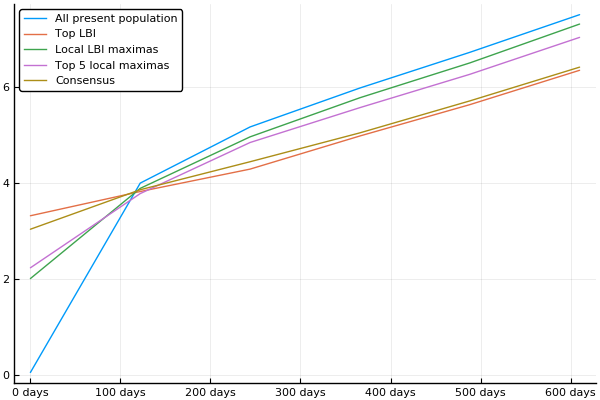

In [334]:
p = plot([x[1] for x in sort(allpop)], [x[2] for x in sort(allpop)], label="All present population")
plot!(p, [x[1] for x in sort(toplbi)], [x[2] for x in sort(toplbi)], label="Top LBI")
plot!(p, [x[1] for x in sort(localmax)], [x[2] for x in sort(localmax)], label="Local LBI maximas")
plot!(p, [x[1] for x in sort(top5localmax)], [x[2] for x in sort(top5localmax)], label="Top 5 local maximas")
plot!(p, [x[1] for x in sort(cons)], [x[2] for x in sort(cons)], label="Consensus")

In [340]:
6/566

0.01060070671378092

In [359]:
# For a specific datebin
i = 41
db = datebins[i]
println("Ref datebin: $db")
predictor_all = get_predictor(llm[db], sp)[1]
predictor_top = get_predictor(llm[db], sp, 1)[1]
predictor_top_5 = get_predictor(llm[db], sp, min(5, length(llm[db])))[1]
predictor_allpop = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db]])
predictor_cons = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(FluTools.consensus(sp.datebin[db]).aa_seq)])
println("days: TopLBI - Consensus - All pop ")
for db2 in datebins[i:i+6]
    future_distribution = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db2]])
#     # using all maximas
#     emd = EarthMoversDistance.EMD(predictor_all, future_distribution).emd
#     localmax[db2[1] - db[1]] = get(localmax, db2[1] - db[1], 0.) + emd / (length(datebins)-12)
#     # Using top  lbi
    emd_toplbi = EarthMoversDistance.EMD(predictor_top, future_distribution).emd
#     toplbi[db2[1] - db[1]] = get(toplbi, db2[1] - db[1], 0.) + emd / (length(datebins)-12)
#     # Using all current population
    emd_allpop = EarthMoversDistance.EMD(predictor_allpop, future_distribution).emd
#     allpop[db2[1] - db[1]] = get(allpop, db2[1] - db[1], 0.) + emd / (length(datebins)-12)
#     # Using top 5 local maxima
#     emd = EarthMoversDistance.EMD(predictor_top_5, future_distribution).emd
#     top5localmax[db2[1] - db[1]] = get(top5localmax, db2[1] - db[1], 0.) + emd / (length(datebins)-12)
#     # Using consensus
    emd_cons = EarthMoversDistance.EMD(predictor_cons, future_distribution).emd
    cons[db2[1] - db[1]] = get(cons, db2[1] - db[1], 0.) + emd / (length(datebins)-12)    
    println(db2[1]-db[1], ": ", emd_toplbi, " - ", emd_cons, " - ", emd_allpop)
end

Ref datebin: (2016-04-11, 2016-08-11)
days: TopLBI - Consensus - All pop 
0 days: 5.5353541064425436 - 5.5353541064425436 - -0.031068300023763852
122 days: 5.636364060799327 - 5.636364060799327 - 3.474917193449806
244 days: 4.727272810939542 - 4.727272810939542 - 6.03110069982044
366 days: 6.590000193383814 - 6.590000193383814 - 7.120785041622318
488 days: 7.632663455910119 - 7.632663455910119 - 7.711268411039152
610 days: 7.660000163994615 - 7.660000163994615 - 7.659954573981565
732 days: 8.212121427030938 - 8.212121427030938 - 8.11915043425216


In [376]:
db = datebins[25]
println(db)
db2 = datebins[29]
cons1 = FluTools.consensus(sp.datebin[db])
tmp1 = [BioTools.hamming(LongAminoAcidSeq(x.aa_seq), LongAminoAcidSeq(cons1.aa_seq)) for x in sp.datebin[db2]];


(2010-12-07, 2011-04-08)


In [377]:
pop1 = sp.datebin[db]
pop2 = sp.datebin[db2]
FluTools.popdistance([cons1], pop2)*566

9.477799436257763

## Are lbi and number of closest leaves correlated? 

In [426]:
include("functions/Predictions.jl")

cluster_lbi_maxima! (generic function with 1 method)

In [13]:
clusters = cluster_lbi_maxima!(t, sp);
db = datebins[end-8]
clusters[db]
println(db)

(2015-08-11, 2015-12-11)


In [520]:
function get_predictor(clusters::Dict, sp)
    Z = Float64(sum(length(x[2]) for x in clusters))
    out = Dict{BioSequence, Float64}()
    for c in values(clusters)
        cons = FluTools.consensus([sp.straindict[x] for x in c])
        seq = LongAminoAcidSeq(cons.aa_seq)
        out[seq] = get(out, seq, 0.) + length(c) / Z
    end
    return out
end

get_predictor (generic function with 3 methods)

In [534]:
idx = 1:length(datebins)-8
dat_cons = Dict(); dat_clusters = Dict(); dat_all = Dict()
for i in idx
    db = datebins[i]
    println(db)
    predictor_cons = Dict(LongAminoAcidSeq(FluTools.consensus(sp.datebin[db]).aa_seq) => 1.)
    predictor_clusters = get_predictor(clusters[db], sp)
    predictor_all = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db]])
    for db2 in datebins[i:i+8]
        future_distribution = EarthMoversDistance.sequence_distribution([LongAminoAcidSeq(x.aa_seq) for x in sp.datebin[db2]])
        # Consensus
        emd = EarthMoversDistance.EMD(predictor_cons, future_distribution).emd
        dat_cons[db2[1]-db[1]] = get(dat_cons, db2[1] - db[1], 0.) + emd / length(idx)
        # Clusters
        emd = EarthMoversDistance.EMD(predictor_clusters, future_distribution).emd
        dat_clusters[db2[1]-db[1]] = get(dat_clusters, db2[1] - db[1], 0.) + emd / length(idx)
        # All present population
        emd = EarthMoversDistance.EMD(predictor_all, future_distribution).emd
        dat_all[db2[1]-db[1]] = get(dat_all, db2[1] - db[1], 0.) + emd / length(idx)
    end
end
dat_cons = sort(dat_cons); dat_clusters = sort(dat_clusters); sort(dat_all)

(2002-12-01, 2003-04-02)
(2003-04-02, 2003-08-02)
(2003-08-02, 2003-12-02)
(2003-12-02, 2004-04-02)
(2004-04-02, 2004-08-02)
(2004-08-02, 2004-12-02)
(2004-12-02, 2005-04-03)
(2005-04-03, 2005-08-03)
(2005-08-03, 2005-12-03)
(2005-12-03, 2006-04-04)
(2006-04-04, 2006-08-04)
(2006-08-04, 2006-12-04)
(2006-12-04, 2007-04-05)
(2007-04-05, 2007-08-05)
(2007-08-05, 2007-12-05)
(2007-12-05, 2008-04-05)
(2008-04-05, 2008-08-05)
(2008-08-05, 2008-12-05)
(2008-12-05, 2009-04-06)
(2009-04-06, 2009-08-06)
(2009-08-06, 2009-12-06)
(2009-12-06, 2010-04-07)
(2010-04-07, 2010-08-07)
(2010-08-07, 2010-12-07)
(2010-12-07, 2011-04-08)
(2011-04-08, 2011-08-08)
(2011-08-08, 2011-12-08)
(2011-12-08, 2012-04-08)
(2012-04-08, 2012-08-08)
(2012-08-08, 2012-12-08)
(2012-12-08, 2013-04-09)
(2013-04-09, 2013-08-09)
(2013-08-09, 2013-12-09)
(2013-12-09, 2014-04-10)
(2014-04-10, 2014-08-10)
(2014-08-10, 2014-12-10)
(2014-12-10, 2015-04-11)
(2015-04-11, 2015-08-11)
(2015-08-11, 2015-12-11)


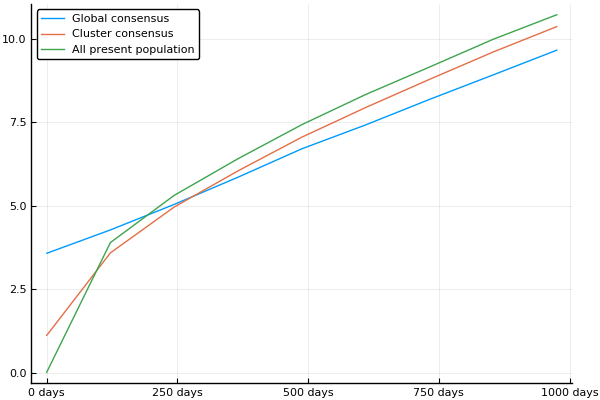

In [537]:
plot([x[1] for x in dat_cons], [x[2] for x in dat_cons], label="Global consensus")
plot!([x[1] for x in dat_clusters], [x[2] for x in dat_clusters], label="Cluster consensus")
plot!([x[1] for x in dat_all], [x[2] for x in dat_all], label="All present population")

In [538]:
6.5/3/566

0.0038280329799764428

In [550]:
divtimes = []
for db in datebins
    pop = sp.datebin[db]
    for i in 1:length(pop)
        for j in (i+1):length(pop)
            push!(divtimes, TreeTools.node_divtime(t.lleaves[pop[i].strain], t.lleaves[pop[j].strain])/2 / 0.004 * 365)
        end
    end
end

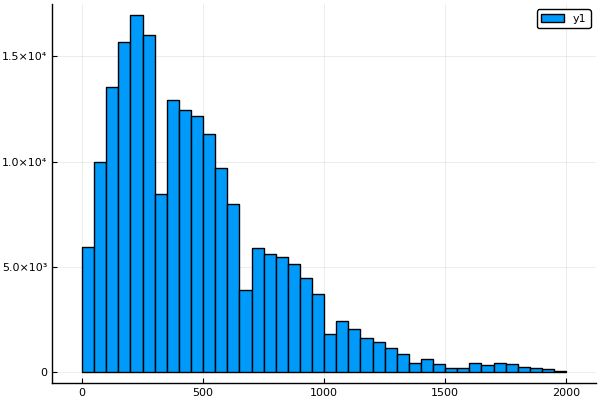

In [554]:
histogram(divtimes, bins = 0:50:2000)

In [546]:
db = datebins[39]
pop = sp.datebin[db]
i = 1
j = 2
TreeTools.node_divtime(t.lleaves[pop[i].strain], t.lleaves[pop[j].strain])

0.01952301

In [549]:
0.019 / 0.004 

4.75